# Predicting West Nile Virus - Kaggle Competition
### Jenny Doyle, Joseph Brown, Mark Mummert

[Tasks](https://trello.com/b/EsEm4u65/kaggle-group-project)
[Presentation](https://docs.google.com/presentation/d/1OYMH0lvh7J6uIr0cuL9AxoyFtUaxgkqxYWKBzyuXG-A/edit?usp=sharing)
[Write-up](https://docs.google.com/document/d/1OQLiP7EnFjc8AtIFAX2H-H3zBbirbs6enUWPgddmggY/edit)

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# pip install pandas-profiling
import pandas_profiling as pdp
import seaborn as sns
%matplotlib inline
import time
import datetime

traps = pd.read_csv('assets/train.csv')
test = pd.read_csv('assets/test.csv')
spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# EDA

## Traps

In [2]:
pdp.ProfileReport(traps)

Number of variables,12
Number of observations,10506
Total Missing (%),0.0%
Total size in memory,985.0 KiB
Average record size in memory,96.0 B
Numeric,6
Categorical,6
Date,0
Text (Unique),0
Rejected,0
Distinct count,138


From this profile report of traps, there are a few things we found important and will deal with:
- the multiple address features seem irrelevant with Latitude and Longitude. Remove them
- WnvPresent has nearly 95% zero!!! We will need to stratify our training data so that the negative class doesn't dominate the results
- Species has 7 categorical values: create dummies
- Date feature should be converted to date datatype
- 813 duplicate rows: We know from the data descriptions that observations are capped at 50 mosquitos, so it's definitely possible that a single observation spans a couple of records. We'll leave the duplicates for this reason, and sum up the number of mosquitos with a groupby.

In [2]:
## We can tackle the multiple addresses and the grouping in this one step
traps = traps[['Trap',
               'Latitude',
               'Longitude',
               'Date',
               'Species',
               'WnvPresent',
               'NumMosquitos']].groupby(['Trap',
                                         'Latitude',
                                         'Longitude',
                                         'Date', 
                                         'Species',
                                         'WnvPresent']).agg({'NumMosquitos':np.sum}).reset_index()

feats = traps.columns

## get species dummies and add to traps df
traps = pd.get_dummies(traps, columns=['Species'])

## convert to date
traps.Date = pd.to_datetime(traps.Date)

Let's look at the features that we'll have when we run our test data through the models:

In [3]:
test.columns

Index([u'Id', u'Date', u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy'],
      dtype='object')

In [4]:
# The test data doesn't include NumMosquitos... 
# this means we should drop this column from traps 
# and then drop the duplicates

traps.drop('NumMosquitos',axis=1,inplace=True)
traps.drop_duplicates(inplace=True)


## Might as well go ahead and perform the same modifications on the test data

# remove the redundant address features from test
test = test[feats.drop(['WnvPresent','NumMosquitos'])]

## get species dummies and add to traps df
test = pd.get_dummies(test, columns=['Species'])

## convert to date
test.Date = pd.to_datetime(test.Date)

## Spray

In [6]:
pdp.ProfileReport(spray)

Number of variables,4
Number of observations,14835
Total Missing (%),1.0%
Total size in memory,463.7 KiB
Average record size in memory,32.0 B
Numeric,2
Categorical,2
Date,0
Text (Unique),0
Rejected,0
Distinct count,10


This is a really simple dataset. There are missing values in time, but it doesn't seem like a significant feature as it's too specific and variable. We will exclude Time, and don't have any modifications to make aside from converting the Date feature into date type. 

In [5]:
spray.Date = pd.to_datetime(spray.Date)

In [6]:
spray.duplicated().sum()

541

In [7]:
# Drop the duplicate records
spray.drop_duplicates(inplace=True)

## Weather

In [10]:
pdp.ProfileReport(weather)

Number of variables,22
Number of observations,2944
Total Missing (%),0.0%
Total size in memory,506.1 KiB
Average record size in memory,176.0 B
Numeric,5
Categorical,15
Date,0
Text (Unique),0
Rejected,2
Distinct count,178


Important notes from the profile report:
- Need to convert Date to actual date datatype
- The weather data has 2 weather observations per date, one from station 1 and the other from station 2. Maybe we only need data from one station. After looking at the sample of the data in the profile report, it looks like there might be a difference in the amount of 'M'==missing values
- Several features should be numeric datatypes, but contain indicators like 'T' or 'M' that need to be removed. T = trace, M = missing. Need to clean up these features
- CodeSum: any code in this feature indicates a significant weather event, so we can turn this into a binary feature indicating whether or not a significant weather event occurred
- Tavg has more missing values than Tmin, Tmax, so we will just set it to the average of Tmin and Tmax

In [8]:
weather.Date = pd.to_datetime(weather.Date)

In [9]:
# skip the numeric columns, because they can't contain the 'M' string
check_missing_values = ['Depart','Heat','Cool','Sunrise','Sunset','Depth','Water1','SnowFall']
for col in weather[check_missing_values]:
    station_1 = len(weather[(weather[col].str.contains('\D')) & (weather.Station==1)])
    print col + ' has ' + str(station_1) + ' missing values at station 1'
    station_2 = len(weather[(weather[col].str.contains('\D')) & (weather.Station==2)])
    print col + ' has ' + str(station_2) + ' missing values at station 2'
    print ''

Depart has 1271 missing values at station 1
Depart has 1472 missing values at station 2

Heat has 0 missing values at station 1
Heat has 11 missing values at station 2

Cool has 1096 missing values at station 1
Cool has 1021 missing values at station 2

Sunrise has 0 missing values at station 1
Sunrise has 1472 missing values at station 2

Sunset has 0 missing values at station 1
Sunset has 1472 missing values at station 2

Depth has 0 missing values at station 1
Depth has 1472 missing values at station 2

Water1 has 1472 missing values at station 1
Water1 has 1472 missing values at station 2

SnowFall has 1472 missing values at station 1
SnowFall has 1472 missing values at station 2



It looks like station 2 consistently has more missing values, so let's stick to using station 1 as our weather source.

In [10]:
weather = weather[weather.Station==1].drop('Station',axis=1)

Actually, a bunch of the features are 0 and won't give us any information. We'll remove them:

In [11]:
exclude = ['Depart','Heat','Cool','Sunrise','Sunset','Depth','Water1','SnowFall']
include = weather.columns.drop(exclude)
weather = weather[include]

weather.columns

Index([u'Date', u'Tmax', u'Tmin', u'Tavg', u'DewPoint', u'WetBulb', u'CodeSum',
       u'PrecipTotal', u'StnPressure', u'SeaLevel', u'ResultSpeed',
       u'ResultDir', u'AvgSpeed'],
      dtype='object')

In [12]:
# clean up features that should be numeric

# the PrecipTotal column contains the letter 'T' in some rows
# this indicates a 'trace' amount of precipitation, which is
# defined as less than 0.005
# 'M' indicates missing data

def clean_col(column):
    weather[column] = weather[column].str.replace('T','0.005')
    weather[column] = weather[column].str.replace('M','0.0')
    weather[column] = weather[column].astype(float)


    
clean_col('Tavg')
clean_col('PrecipTotal')
clean_col('WetBulb')
clean_col('StnPressure')
clean_col('SeaLevel')
clean_col('AvgSpeed')
# columns = ['Tavg','PrecipTotal','WetBulb','StnPressure','SeaLevel','AvgSpeed']
# for col in columns:
#     clean_col(col)

# If the CodeSum contains letters, they signify some type
# of significant weather event. Let's instead flag these as 1
# and then 0 for the values that are just whitespace
weather.CodeSum = weather.CodeSum.str.strip()
weather.CodeSum[weather.CodeSum.str.contains('^\w')] = '1'
weather.CodeSum[weather.CodeSum!='1'] = '0'
weather.CodeSum = weather.CodeSum.astype(float)

# fill in missing Tavg by just taking the avg of Tmin and Tmax
# while this is not how Tavg is calculated, but it's probably close
weather['Tavg'][weather.Tavg==0] = (weather.Tmin + weather.Tmax) / 2

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Modified Features -- Look at pairplots 

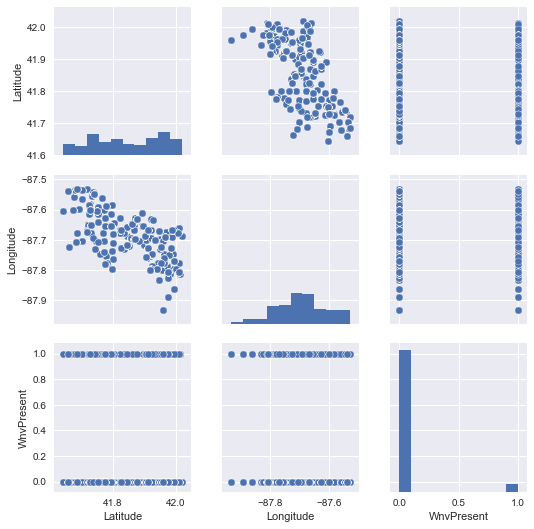

In [13]:
no_dummies = [x for x in traps.columns if not 'Species_' in x]
sns.pairplot(traps[no_dummies])

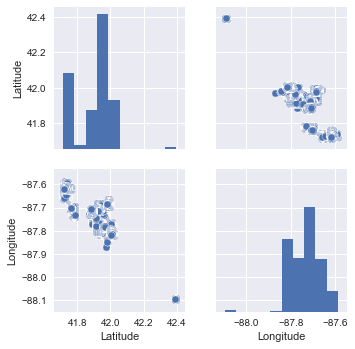

In [14]:
sns.pairplot(spray)

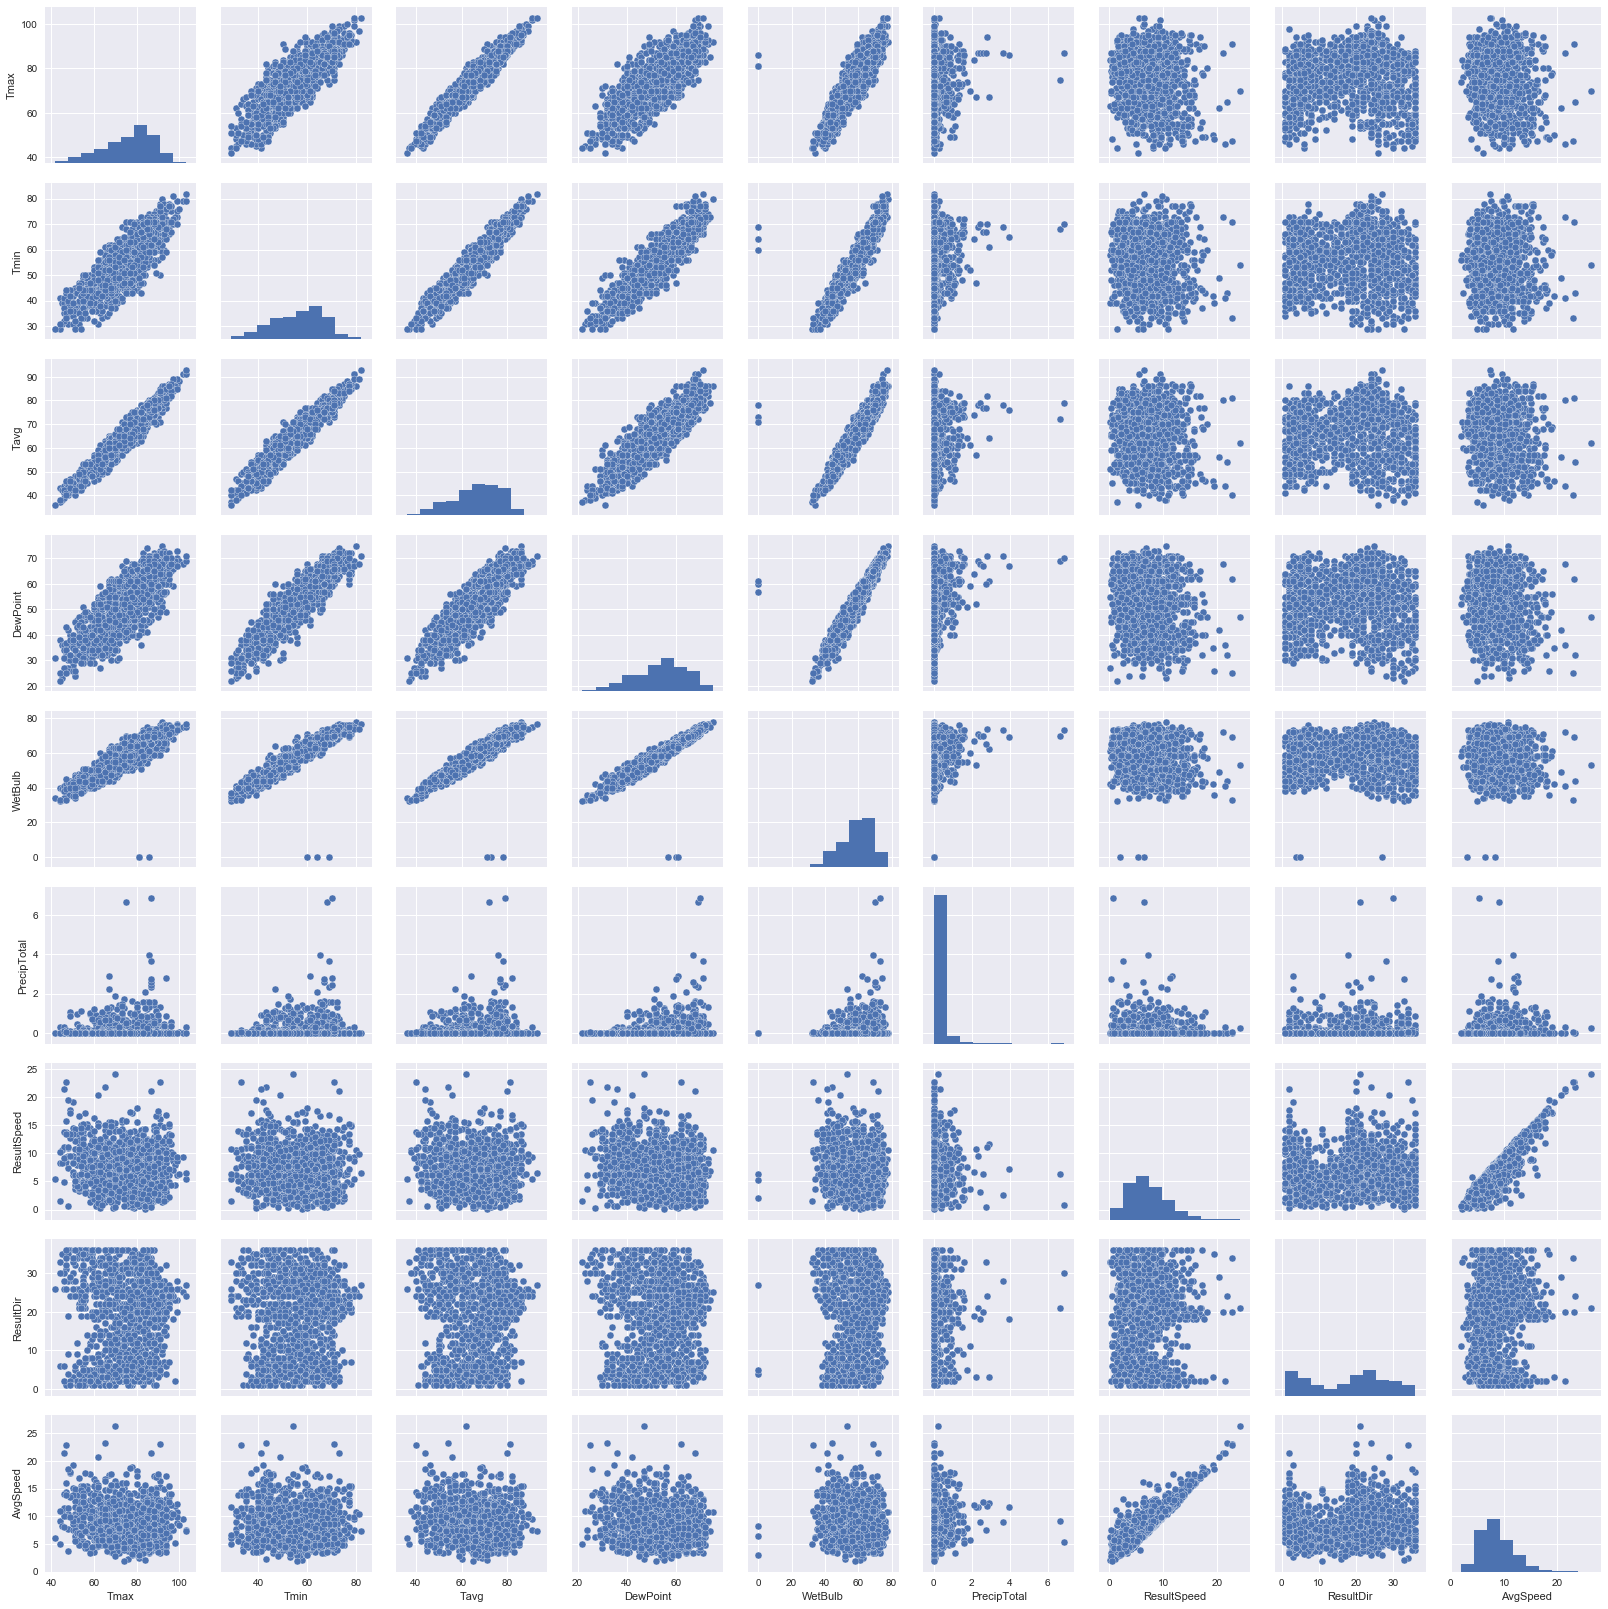

In [15]:
no_dummies = weather.columns.drop(['CodeSum','SeaLevel','StnPressure'])
sns.pairplot(weather[no_dummies])

# Create More Features

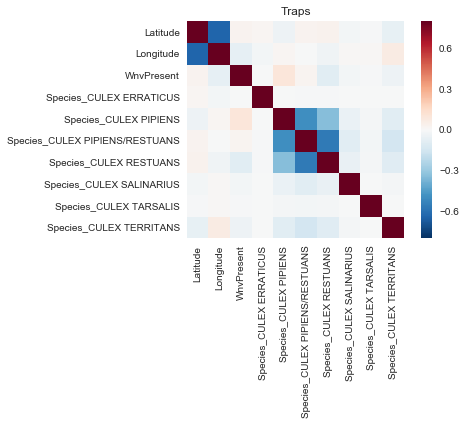

In [16]:
#Before adding anything, let's see what the feature correlation looks like
def find_correlation(data,title):
    correlation = data.corr()
    sns.heatmap(correlation, vmax=.8, square=True)
    plt.title(title)

find_correlation(traps, 'Traps')

In [17]:
## Parse Dates to see if they can be used in the modeling
traps['year']  = traps['Date'].dt.year
traps['month'] = traps['Date'].dt.month
traps['day']   = traps['Date'].dt.day

## Add Weather data

This function will add weather features to our traps df, and takes three arguments:
- the column name as a string from weather dataframe that we want to extract
- a numpy function that we want to do to the data
- an integer number of previous days to extract

In [18]:
def weather_add(df, weather_col, func, days_range=7):
    new_list = []
    for i in df['Date']:
        mask = (weather['Date'] <= i) & (weather['Date'] >= i - pd.Timedelta(days=days_range))
        data_list = func(weather[weather_col][mask])
        new_list.append(data_list)
    return new_list

In [19]:
## running this cell will extract the average temp min, average temp max, and precipitation sum 
## to the traps dataframe from the previous 7 days, unless otherwise specified

traps['Tmax']    = weather_add(traps, weather_col='Tmax', func=np.mean)
traps['Tmin']    = weather_add(traps, weather_col='Tmin', func=np.mean)
traps['PrecipTotal']    = weather_add(traps, weather_col='PrecipTotal', func= np.sum)
traps['Tmax_3']  = weather_add(traps, weather_col='Tmax', func=np.mean, days_range=3)
traps['Tmax_20'] = weather_add(traps, weather_col='Tmax',func=np.mean, days_range=20)
traps['DewPoint']     = weather_add(traps, weather_col ='DewPoint', func=np.mean, days_range = 10)
traps['Tmin_3']  = weather_add(traps, weather_col='Tmin', func=np.mean, days_range=3)
traps['Tmin_20'] = weather_add(traps, weather_col='Tmin', func=np.mean, days_range=20)

for col in ['Tavg','WetBulb','CodeSum','StnPressure','SeaLevel', 'ResultSpeed', 'ResultDir','AvgSpeed']:
    traps[col] = weather_add(traps, weather_col=col, func=np.mean)

## Add Spray data

This function will add spray features to our traps df, and takes 5 arguments:
- dataframe that will be added to
- start: integer number of days from trap inspection (closer to date)
- stop: integer number of days from trap inspection (farther from date) 
- col: spray column with the closest distance of spray
- Spray_col: spray column with the number of days since that spray

In [5]:
def add_cols(traps,start,stop,col,Spray_col):
    # ex) I want the week leading up to the inspection date: start = 0, end = 7
    # ex) I want the week before that: start = 7, end = 14
    from geopy.distance import vincenty
    traps_sprayed = traps[traps[Spray_col].isnull()].index.values
    remaining = len(traps_sprayed)   
    
    for i in traps_sprayed:
        if start>0: # subtract # of days from the date the trap is inspected
            start_date = traps.Date.loc[i] - pd.Timedelta(days=start) 
        else: # if start=0, then we're starting on the trap inspection day and collecting data backwards
            start_date = traps.Date.loc[i]
        end_date = traps.Date.loc[i] - pd.Timedelta(days=stop)
        dates = pd.date_range(start=end_date, end=start_date).tolist() # create list of all dates in our start, end points
        trap_lat = traps.Latitude.loc[i]
        trap_long = traps.Longitude.loc[i]
        dist = []

        # for each dated trap inspection, select only the spray records within the date range
        spray_temp = spray[['Latitude','Longitude','Date']][spray.Date.isin(dates)]
        
        remaining-=1 # counts how many records are left to process
        print str(remaining),' remaining'

        # run through each coordinate in the spray data and record the distance from our trap
        for j in range(0,len(spray_temp)):
            spray_lat = spray_temp.Latitude.iloc[j] 
            spray_long = spray_temp.Longitude.iloc[j]
            a = (trap_lat, trap_long) # trap coordinates
            b = (spray_lat, spray_long) # spray coordinates
            dist.append(vincenty(a, b).miles) # calculate the distance between the points
        
        try:
            # set the spray value to the shortest distance
            traps[Spray_col].loc[i] = min(dist)
            dt = dist.index(min(dist))
            spray_dt = spray_temp.Date.iloc[dt]
            # record the number of days from inspection that the nearest spray occurred
            traps[col].loc[i] = pd.Timedelta(traps.Date.loc[i]-spray_dt).days
        except:
            pass

In [ ]:
# get the indicies of trap data that actually have spray data
traps_spray = traps[traps.Year.isin([2011,2013])]

# create the columns
traps_spray['Spray_Dist'] = np.NaN
traps_spray['Spray_Days_Ago'] = np.NaN

# week leading up to inspection
add_cols(traps_spray,0,7,'Spray_Days_Ago','Spray_Dist')
#one week out
add_cols(traps_spray,7,14,'Spray_Days_Ago','Spray_Dist')
# two weeks out
add_cols(traps_spray,14,21,'Spray_Days_Ago','Spray_Dist')
# three weeks out
add_cols(traps_spray,21,28,'Spray_Days_Ago','Spray_Dist')
# four weeks out
add_cols(traps_spray,28,35,'Spray_Days_Ago','Spray_Dist')

In [ ]:
# Check to see how many values we were able to fill in
traps['Spray'].isnull().sum()/float(len(traps['Spray']))

Nope. Not going to include spray data. We could potentially model the spray data from 2011, 2013 to predict values for 2007, 2009 to fill our data, but we didn't have time to go down that path.

In [ ]:
traps.drop(['Spray_Dist','Spray_Days_Ago'],axis=1,inplace=True)

In [23]:
## Save the transformed tables so we don't have to run the earlier cells
# traps.to_csv('./assets/Train_transformed/traps_jd.csv', encoding='utf-8', index=False)

In [2]:
##re-import the altered traps file if re-running and want to skip steps above
# traps = pd.read_csv('./assets/Train_transformed/traps_jd.csv')

# Feature Selection

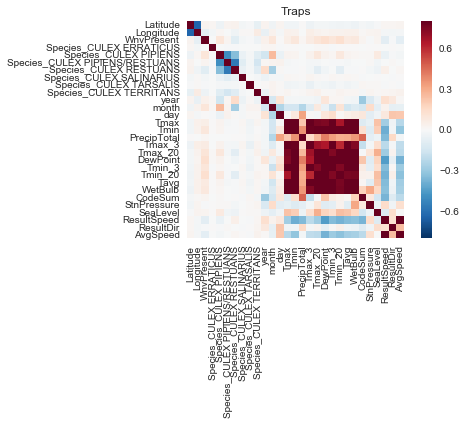

In [20]:
## Check out how the correlation map changed with our new features
find_correlation(traps, 'Traps')

In [24]:
X.columns

Index([u'Latitude', u'Longitude', u'Species_CULEX ERRATICUS',
       u'Species_CULEX PIPIENS', u'Species_CULEX PIPIENS/RESTUANS',
       u'Species_CULEX RESTUANS', u'Species_CULEX SALINARIUS',
       u'Species_CULEX TARSALIS', u'Species_CULEX TERRITANS', u'year',
       u'month', u'day', u'Tmax', u'Tmin', u'PrecipTotal', u'Tmax_3',
       u'Tmax_20', u'DewPoint', u'Tmin_3', u'Tmin_20', u'Tavg', u'WetBulb',
       u'CodeSum', u'StnPressure', u'SeaLevel', u'ResultSpeed', u'ResultDir',
       u'AvgSpeed'],
      dtype='object')

In [21]:
# Get rid of features that we cannot use
features = traps.columns.drop(['WnvPresent','Date','Trap'])

X = traps[features]
y = traps.WnvPresent

In [36]:
## slightly adapted from: http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

# from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.feature_selection import RFECV, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# create a function that scales the data, takes the data
# and scores the features, storing it in a dictionary, ranks
def rank_to_dict(ranks, names, order=1):
    minmax = StandardScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

ranks = {}

lr = RandomizedLogisticRegression()
lr.fit(X, y)
ranks["Logistic"] = rank_to_dict(np.abs(lr.scores_), features)
    
rf = RandomForestClassifier()
rf.fit(X,y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, features)

f, pval  = f_classif(X, y)
ranks["F_Classif."] = rank_to_dict(f, features)

r = {}
for name in features:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())

# average out the scores
ranks["Mean"] = r
methods.append("Mean")


# Now that we have our data, convert to dataframe for better viewing
feats = []
names = []

# feature names
for i in ranks['RF']:
    names.append(i)

feats.append(names)

# feature importances
for i in ranks:
    row = []
    for j in ranks[i]:
        row.append(ranks[i][j])
    feats.append(row)

feats_t = []

for i in range(0,len(features)):
    row = []
    for f in feats:
        row.append(f[i])
    feats_t.append(row)

feature_importances = pd.DataFrame(feats_t,columns = ['Feature','F_Classif','Logistic','RF','Mean'])

In [95]:
feature_importances.sort_values(['Mean'],ascending=False)

# feature_importances.sort_values(['Mean','F_Classif','Logistic','RF'],ascending=False)
# feature_importances.Feature

,Feature,F_Classif,Logistic,RF,Mean
18,Longitude,3.59,0.14,1.52,1.75
15,DewPoint,-0.23,2.47,1.99,1.41
5,Tmin_20,-0.28,2.44,1.94,1.37
2,month,-0.27,0.92,2.12,0.92
1,Species_CULEX PIPIENS,-0.07,0.89,1.76,0.86
9,Species_CULEX RESTUANS,-0.14,0.75,1.81,0.81
4,Latitude,3.60,-0.79,-0.63,0.73
10,Tmax_20,-0.26,1.25,0.06,0.35
16,Tmin_3,-0.30,0.90,0.24,0.28
20,ResultSpeed,-0.27,0.54,0.09,0.12


Cutting off the features at Tmin_3--use all above it. Also, this has been re-run several times and somehow the Species_CULEX RESTUANS shot up the ranks. This feature, however, wasn't used in any of our models, so it will not be included.

In [98]:
features_new = list(feature_importances.sort_values(['Mean','F_Classif','Logistic','RF'],ascending=False)['Feature'][0:9])
features_new.remove('Species_CULEX RESTUANS')

In [103]:
X = traps[features_new]
y = traps.WnvPresent

# Scale the Data

We will use the StandardScaler to scale our data for us in the RandomForest models and SVM models. We'll also just keep the regular data for comparison

In [104]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize

X_s = pd.DataFrame(StandardScaler().fit_transform(X[X.columns.drop('Species_CULEX PIPIENS')]),columns=X.columns.drop('Species_CULEX PIPIENS'))
X_s = pd.DataFrame(X['Species_CULEX PIPIENS']).merge(X_s,left_on=X.index.values, right_on=X_s.index.values)
X_s.drop('key_0',inplace=True,axis=1)

# Train-Test Split

Creating a stratified train-test split to evaluate our models. Stratified because, as noted above, zeroes dominate WnvPositive at 94%.

In [55]:
from sklearn.model_selection import train_test_split

Split the raw, unscaled data

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.33, stratify=y)

Split the scaled data

In [106]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s,y,train_size=.33, stratify=y)

Check that both sets have identical shape

In [107]:
print 'Raw splits:'
print X_train.shape, X_test.shape, y_test.shape, y_train.shape
print
print 'Scaled splits:'
print X_train_s.shape, X_test_s.shape, y_test_s.shape, y_train_s.shape

Raw splits:
(2841, 8) (5769, 8) (5769,) (2841,)

Scaled splits:
(2841, 8) (5769, 8) (5769,) (2841,)


# Building the Models

Create a function that we will use to evaluate our models. It will return the ROC score that we can use to see how well it will do on Kaggle.

In [48]:
from sklearn.metrics import roc_auc_score

def score_model(model,X_test,y_test):
    preds = model.predict_proba(X_test)
    pred_list =[]
    
    for x in preds:
        pred_list.append(x[1])
        
    roc_score = roc_auc_score(y_test, pred_list)
    return roc_score

## (1/6) Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RF = RandomForestClassifier(n_estimators = 1000, 
                            bootstrap=True, 
                            max_depth=5,
                            max_features='auto',
                            min_samples_leaf= 1, 
                            min_samples_split= 2)

Using raw data

In [108]:
RF_model= RF.fit(X_train, y_train)
score_model(RF_model,X_test,y_test)
# 0.86780509496634572

0.82547715528947552

Using StandardScaled data

In [109]:
RF_model_s = RF.fit(X_train_s, y_train_s)
score_model(RF_model_s,X_test_s, y_test_s)
# 0.81161294220537694

0.82209462587890736

## (2/6) Support Vector Machine

In [111]:
from sklearn.svm import SVC

SVM with kernel = 'rbf'

In [112]:
svmc= SVC(probability=True)
svm_model = svmc.fit(X_train,y_train)
score_model(svm_model,X_test,y_test)
# 0.30215737665155207

0.29652750110966347

In [113]:
svm_model_s = svmc.fit(X_train_s,y_train_s)
score_model(svm_model_s,X_test_s,y_test_s)

0.7412381451451775

Scaled data performed significantly better.

Try with the linear kernel by using bagging and ovr

In [114]:
# credit: first answer on http://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python

import time
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


start = time.time()
clf1 = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf1.fit(X_train, y_train)
end = time.time()
print "Single SVC", end - start, clf1.score(X_test,y_test), score_model(clf1,X_test,y_test)

n_estimators = 10
start = time.time()
clf2 = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
clf2.fit(X_train, y_train)
end = time.time()
print "Bagging SVC", end - start, clf2.score(X_test,y_test), score_model(clf2,X_test,y_test)


# Single SVC 4.18354606628 0.671693534408 0.754635462093
# Bagging SVC 0.904535055161 0.787831513261 0.746318070825

Single SVC 3.76783299446 0.655746229849 0.764287440524
Bagging SVC 0.574933052063 0.768070722829 0.752589015349


Try with the scaled data

In [115]:
# credit: first answer on http://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python

import time
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


start = time.time()
clf1s = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf1s.fit(X_train_s, y_train_s)
end = time.time()
print "Single SVC", end - start, clf1s.score(X_test_s,y_test_s), score_model(clf1s,X_test_s,y_test_s)

n_estimators = 10
start = time.time()
clf2s = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
clf2s.fit(X_train_s, y_train_s)
end = time.time()
print "Bagging SVC", end - start, clf2s.score(X_test_s,y_test_s), score_model(clf2s,X_test_s,y_test_s)


# Single SVC 1.21880817413 0.680013867221 0.751182644026
# Bagging SVC 0.137820005417 0.718495406483 0.744525261444

Single SVC 1.31022405624 0.648812619171 0.772368542267
Bagging SVC 0.167356967926 0.73565609291 0.762660332911


## (3/6) Logistic Regression

In [116]:
#LOGISTIC REGRESSION
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
def log(X,y,X_test,y_test):
    # flatten y into a 1-D array
    y_log = np.ravel(y)
    model = LogisticRegression()
    model = model.fit(X, y)
    predicted = model.predict(X_test)
    probs = model.predict_proba(X_test)
    scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
    print 'Mean CV score: ' + str(scores.mean())
    print 'Accuracy score: ' + str(metrics.accuracy_score(y_test, predicted))
    print 'Roc-auc score: ' + str(metrics.roc_auc_score(y_test, probs[:, 1]))
    print ''
    print 'Confusion matrix: \n' + str(metrics.confusion_matrix(y_test, predicted))
    print 'Classification report: \n' + str(metrics.classification_report(y_test, predicted))
    # check the accuracy on the training set
    print 'Model score: ' + str(model.score(X_test, y_test))
    print 'Kaggle: ' + str(score_model(model,X_test,y_test))
    print ''


log(X_train,y_train,X_test,y_test)
log(X_train_s,y_train_s,X_test_s,y_test_s)


# Mean CV score: 0.946850753645
# Accuracy score: 0.946957878315
# Roc-auc score: 0.734609476227
    
# Mean CV score: 0.946850753645
# Accuracy score: 0.946957878315
# Roc-auc score: 0.761849471011

Mean CV score: 0.946850753645
Accuracy score: 0.946957878315
Roc-auc score: 0.747154356282

Confusion matrix: 
[[5463    0]
 [ 306    0]]
Classification report: 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      5463
          1       0.00      0.00      0.00       306

avg / total       0.90      0.95      0.92      5769

Model score: 0.946957878315
Kaggle: 0.747154356282

Mean CV score: 0.946850753645
Accuracy score: 0.946957878315
Roc-auc score: 0.768921108012

Confusion matrix: 
[[5463    0]
 [ 306    0]]
Classification report: 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      5463
          1       0.00      0.00      0.00       306

avg / total       0.90      0.95      0.92      5769

Model score: 0.946957878315
Kaggle: 0.768921108012



The logistic regression model using the scaled data looks okay. Making that model and submitting to kaggle.

In [117]:
# flatten y into a 1-D array
y_log = np.ravel(y_train_s)
log_model = LogisticRegression()
log_model = log_model.fit(X_train_s, y_train_s)

## (4/6) ADA Boost

In [118]:
from sklearn.ensemble import AdaBoostClassifier

In [119]:
adaboost= AdaBoostClassifier()
ada_model=adaboost.fit(X,y)
score_model(ada_model,X_test,y_test)
#0.88491183862121936

0.85638831162460716



## (5/6) Gradient Boost

In [120]:
from sklearn.ensemble import GradientBoostingClassifier

def GradBoostClass(X_train,y_train,X_test,y_test):
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
    clf.score(X_test, y_test)   
    print score_model(clf,X_test,y_test)
    print ''

GradBoostClass(X_train,y_train,X_test,y_test)
GradBoostClass(X_train_s,y_train_s,X_test_s,y_test_s)
# 0.807420448196

# 0.799875933045

0.820344288792

0.821106397285



In [121]:
gradboost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
gradboost.score(X_test, y_test) 

0.94661119778124458

## (6/6) XG Boost

In [122]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier  
import scipy.stats as st

model = XGBClassifier()
xgm = model.fit(X_train, y_train, eval_metric=roc_auc_score)
score_model(xgm,X_test,y_test)
# 0.8723832880791802

0.82574036387390393

### 6a) XGBoost GridSearch

In [73]:
import random

params = {  
    "n_estimators": [3,4,5,7,8,10],
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    'eval_metric' :'auc',
    'objective': ['binary:logistic']
}

xgbclass = XGBClassifier()  


In [56]:
from sklearn.model_selection import RandomizedSearchCV

gs = GridSearchCV(xgbclass,  params, n_jobs=-1, scoring='roc_auc')
gs.fit(X_train, y_train)  

gs.best_estimator_

In [123]:
xg_grid = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

xg_final = xg_grid.fit(X_train, y_train)
score_model(xg_final,X_test,y_test)
# 0.81860621483323937

0.82574036387390393

# Import and Transform Test Data

In [76]:
## Add features
test['Tmax_20'] = weather_add(test, weather_col='Tmax',func=np.mean, days_range=20)
test['DewPoint']= weather_add(test, weather_col ='DewPoint', func=np.mean, days_range = 10)
test['Tmin_3'] = weather_add(test, weather_col='Tmin', func=np.mean, days_range=3)
test['Tmin_20'] = weather_add(test, weather_col='Tmin', func=np.mean, days_range=20)

test['month'] = test['Date'].dt.month

In [78]:
## Export the tranformed test data to a folder in the repo 
## so we don't have to run the above cells every time

# test.to_csv('./assets/Test_transformed/test_transformed_427.csv',sep=',', encoding='utf-8')

In [61]:
# test = pd.read_csv('./assets/Test_transformed/test_transformed_427.csv')

In [81]:
test_X = test[features_new]

In [82]:
test_s = pd.DataFrame(StandardScaler().fit_transform(test_X[test_X.columns.drop(['Species_CULEX PIPIENS'])]),columns=test_X.columns.drop(['Species_CULEX PIPIENS']))
test_s = pd.DataFrame(test_X[['Species_CULEX PIPIENS']]).merge(test_s,left_on=test_X.index.values, right_on=test_s.index.values)
test_s.drop('key_0',inplace=True,axis=1)



# Exporting to test

In [83]:
###This function will takes a model and a model name(as a string), generate predictions, 
### and save that as a CSV labeled with the model name and date.
import time 
import math
def model_and_export(model, model_name,test_X=test_X):
    pred_list = []
    predictions =  model.predict_proba(test_X)
    for x in predictions:
        pred_list.append(x[1])
    indexes=np.arange(1, len(predictions)+1, 1)
    preds_df = pd.DataFrame(data=[indexes, pred_list]).T
    preds_df.columns =['Id','WnvPresent']
    preds_df['Id'] = preds_df.Id.astype(int)
    location = './submissions/{}_{}.csv'.format(model_name, time.strftime("%d_%m_%Y"))
    preds_df.to_csv(location, index=False)
    return
    

In [84]:
model_and_export(RF_model, 'RF_JD*')
# Your submission scored 0.72874

In [85]:
model_and_export(log_model, 'LOG_JD*',test_s)
# Your submission scored 0.72305

In [86]:
model_and_export(clf2s, 'SVM_S*', test_s)
# Your submission scored 0.69906.

In [87]:
model_and_export(ada_model, 'ADABoost_JD*')
# Your submission scored 0.74416.

In [88]:
model_and_export(gradboost, 'GRADBOOST_*')
# Your submission scored 0.64589

In [89]:
model_and_export(xgm, 'XG_JD*')
# Your submission scored 0.75110

In [90]:
model_and_export(xg_final, 'XG_FINAL*')
# Your submission scored 0.71567

### Ensembles

In [ ]:
def ensemble_and_export(model1,model2,test_X,file_name):
    pred_m1 = []
    predictions_m1 =  model1.predict_proba(test_X)
    pred_m2 = []
    predictions_m2 =  model2.predict_proba(test_X)

    for x in predictions_m1:
        pred_m1.append(x[1])

    for x in predictions_m2:
        pred_m2.append(x[1])

    indexes=np.arange(1, len(predictions_m1)+1, 1)

    preds_m1 = pd.DataFrame(data=[indexes, pred_m1]).T
    preds_m1.columns =['Id','WnvPresent']
    preds_m1['Id'] = preds_m1.Id.astype(int)

    preds_m2 = pd.DataFrame(data=[indexes, pred_m2]).T
    preds_m2.columns =['Id','WnvPresent']
    preds_m2['Id'] = preds_m2.Id.astype(int)
    
    ensemble = preds_m1.merge(preds_m2,left_on='Id', right_on='Id')
    
    ensemble['avg'] = (ensemble['WnvPresent_x']+ ensemble['WnvPresent_y']) / 2
    ensemble.rename(columns={'avg':'WnvPresent'},inplace=True)

    ensemble = ensemble[['Id','WnvPresent']]

    location = './submissions/{}_{}.csv'.format(file_name, time.strftime("%d_%m_%Y"))
    ensemble.to_csv(location, index=False)

In [91]:
ensemble_and_export(xgm,ada_model,test_X,'Ensemble_XG_ADA*')
# Your submission scored 0.70831.

In [92]:
ensemble_and_export(xgm,RF_model_s,test_X,'Ensemble_XG_RF*')
# Your submission scored 0.70979.